In [1]:
!pip install sidetable
!pip install pydotplus
!pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sidetable as stb
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Getting The Basic Understanding of the Data 

In [42]:
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')
train['source']='train'
test['source']='test'

df1=pd.concat([train,test],ignore_index=True)
tr_idx = df1['Response'].notnull()
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,508077,Male,39,1,28.0,0,1-2 Year,Yes,33670.0,124.0,133,1.0,train
1,116379,Male,60,1,9.0,1,1-2 Year,Yes,32660.0,26.0,64,0.0,train
2,24159,Female,20,1,43.0,0,< 1 Year,No,2630.0,160.0,283,0.0,train
3,129481,Female,22,1,47.0,0,< 1 Year,Yes,32665.0,26.0,42,0.0,train
4,469280,Male,25,1,28.0,1,< 1 Year,No,21602.0,152.0,293,0.0,train


<ipython-input-43-352ad53b23f1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df=df1.corr()


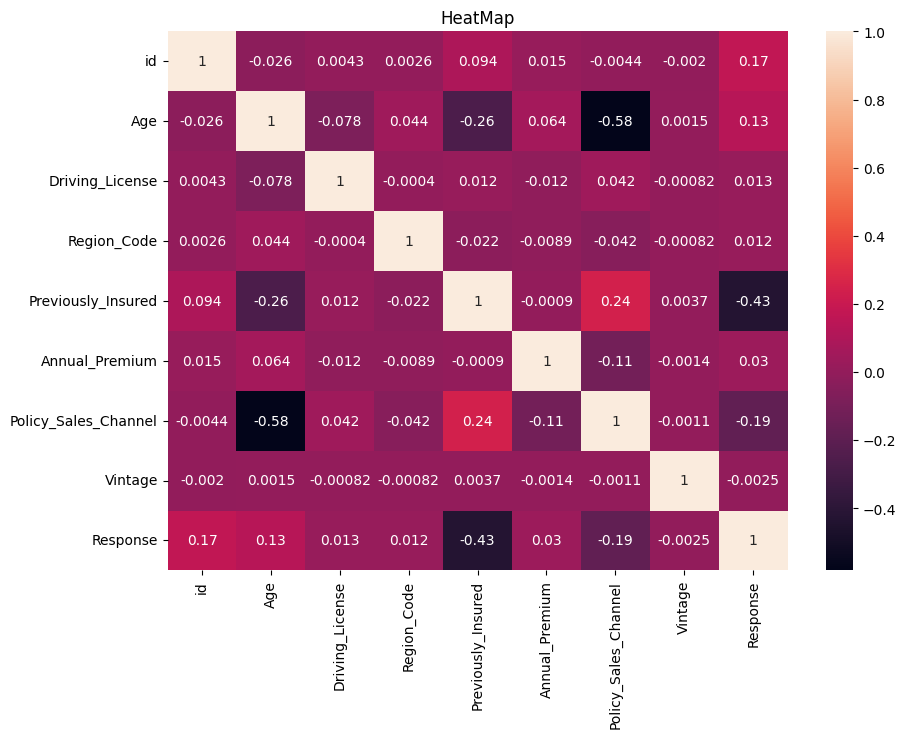

In [43]:
corr_df=df1.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr_df,annot=True)
plt.title('HeatMap')
plt.show()

In [44]:
gender_map={'Male':0,'Female':1}

df1['Gender']=df1['Gender'].map(gender_map)


vehicle_age_map={'1-2 Year':0,'< 1 Year':1,'> 2 Years':2}

df1['Vehicle_Age']=df1['Vehicle_Age'].map(vehicle_age_map)


Vehicle_Damage_map={'Yes':0,'No':1}

df1['Vehicle_Damage']=df1['Vehicle_Damage'].map(Vehicle_Damage_map)

In [45]:
df = df1.copy()

In [46]:
df.loc[(df['Age']>=20) & (df['Age']<29),'Age_label']='Teenagers' ## Just starting out
# df.loc[(df['Age']>=27) & (df['Age']<29),'Age_label']='Young' ## Young Ppl
df.loc[(df['Age']>=29) & (df['Age']<58),'Age_label']='Middle' ## Mid-Age Ppl
df.loc[(df['Age']>=58) & (df['Age']<=85),'Age_label']='Old' ## Old Age

In [47]:
df.loc[(df['Annual_Premium']>=2630.0) & (df['Annual_Premium']<12368.0),'Annual_Premium_label']='Bronze'
df.loc[(df['Annual_Premium']>=12368.0) & (df['Annual_Premium']<35093.0),'Annual_Premium_label']='Silver'
df.loc[(df['Annual_Premium']>=35093.0) & (df['Annual_Premium']<40433.0),'Annual_Premium_label']='Gold'
df.loc[(df['Annual_Premium']>=40433.0) & (df['Annual_Premium']<=540165.0),'Annual_Premium_label']='Diamond'


# df.loc[(df['Annual_Premium']>=2630.0) & (df['Annual_Premium']<9816.0),'Annual_Premium']=0
# df.loc[(df['Annual_Premium']>=9816.0) & (df['Annual_Premium']<38085.0),'Annual_Premium']=1
# df.loc[(df['Annual_Premium']>=38085.0) & (df['Annual_Premium']<46170.0),'Annual_Premium']=2
# df.loc[(df['Annual_Premium']>=46170.0) & (df['Annual_Premium']<=540165.0),'Annual_Premium']=3

In [48]:
df=pd.get_dummies(df,columns=['Age_label','Annual_Premium_label'],drop_first=True)

In [49]:
df.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source,Age_label_Old,Age_label_Teenagers,Annual_Premium_label_Diamond,Annual_Premium_label_Gold,Annual_Premium_label_Silver
0,508077,0,39,1,28.0,0,0,0,33670.0,124.0,133,1.0,train,0,0,0,0,1
1,116379,0,60,1,9.0,1,0,0,32660.0,26.0,64,0.0,train,1,0,0,0,1
2,24159,1,20,1,43.0,0,1,1,2630.0,160.0,283,0.0,train,0,1,0,0,0


In [50]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [51]:
train_df=df.loc[df['source']=='train']
test_df=df.loc[df['source']=='test']

train_df.drop(['source','id'],axis=1,inplace=True)
test_df.drop(['source','id','Response'],axis=1,inplace=True)

<ipython-input-51-e879e59e93e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['source','id'],axis=1,inplace=True)
<ipython-input-51-e879e59e93e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['source','id','Response'],axis=1,inplace=True)


In [52]:
train_df


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_label_Old,Age_label_Teenagers,Annual_Premium_label_Diamond,Annual_Premium_label_Gold,Annual_Premium_label_Silver
0,0,39,1,28.0,0,0,0,33670.0,124.0,133,1.0,0,0,0,0,1
1,0,60,1,9.0,1,0,0,32660.0,26.0,64,0.0,1,0,0,0,1
2,1,20,1,43.0,0,1,1,2630.0,160.0,283,0.0,0,1,0,0,0
3,1,22,1,47.0,0,1,0,32665.0,26.0,42,0.0,0,1,0,0,1
4,0,25,1,28.0,1,1,1,21602.0,152.0,293,0.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244573,0,24,1,28.0,0,0,0,34733.0,122.0,99,0.0,0,1,0,0,1
244574,1,20,1,3.0,0,1,0,33810.0,160.0,10,0.0,0,1,0,0,1
244575,0,38,1,28.0,1,0,1,33419.0,122.0,164,0.0,0,0,0,0,1
244576,1,33,1,28.0,1,0,1,47285.0,124.0,166,0.0,0,0,1,0,0


In [53]:
X=train_df.drop(['Response','Age','Annual_Premium'],axis=1)
y=train_df['Response'].astype('int')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X = scaler.fit_transform(X)
# test_df = scaler.transform(test_df)

In [54]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
print(f"training data: {train_x.shape}\ntest data: {test_x.shape}")


training data: (195662, 13)
test data: (48916, 13)


In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(train_x, train_y)

# X_train_balanced,X_test_balanced,y_train_balanced,y_test_balanced=train_test_split(X_balanced,y_balanced,test_size=0.25,random_state=5)

In [56]:
y_train_data = pd.DataFrame(train_y)
y_train_balanced_data = pd.DataFrame(y_balanced)

In [57]:
from collections import Counter

Counter(y_balanced) , Counter(train_y)


(Counter({0: 163732, 1: 163732}), Counter({0: 163732, 1: 31930}))

In [65]:
xgb=XGBClassifier(learning_rate =0.3,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(X_balanced, y_balanced )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [66]:
y_pred=xgb.predict(X_balanced)
print('ROC-AUC score for XGB: ',roc_auc_score(y_balanced,y_pred))

ROC-AUC score for XGB:  0.906166784745804


In [67]:
from sklearn.metrics import f1_score
print('f1 score for XGB: ',f1_score(y_balanced,y_pred))

f1 score for XGB:  0.9098928168208676


In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_balanced, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90    163732
           1       0.88      0.95      0.91    163732

    accuracy                           0.91    327464
   macro avg       0.91      0.91      0.91    327464
weighted avg       0.91      0.91      0.91    327464



In [63]:
test_df = test_df.drop(['Age','Annual_Premium'],axis=1)
predsTest = xgb.predict(test_df)
predsTest

array([0, 0, 1, ..., 0, 0, 1])

In [64]:
submission = pd.DataFrame({
        "id": test['id'],
        "Response":predsTest
    })
submission.to_csv('1.csv', index=False)

In [69]:
from catboost import CatBoostClassifier

In [91]:
Cat_model1 = CatBoostClassifier(max_depth=10,learning_rate=0.5)
Cat_model1.fit(X_balanced, y_balanced)

0:	learn: 0.3692340	total: 275ms	remaining: 4m 34s
1:	learn: 0.3271344	total: 473ms	remaining: 3m 55s
2:	learn: 0.3158165	total: 801ms	remaining: 4m 26s
3:	learn: 0.3095303	total: 1.23s	remaining: 5m 6s
4:	learn: 0.3054967	total: 1.62s	remaining: 5m 22s
5:	learn: 0.2996460	total: 1.8s	remaining: 4m 58s
6:	learn: 0.2967621	total: 1.92s	remaining: 4m 32s
7:	learn: 0.2950421	total: 2.04s	remaining: 4m 13s
8:	learn: 0.2927805	total: 2.16s	remaining: 3m 58s
9:	learn: 0.2906279	total: 2.3s	remaining: 3m 47s
10:	learn: 0.2904355	total: 2.37s	remaining: 3m 32s
11:	learn: 0.2876870	total: 2.49s	remaining: 3m 25s
12:	learn: 0.2857831	total: 2.61s	remaining: 3m 18s
13:	learn: 0.2849801	total: 2.73s	remaining: 3m 12s
14:	learn: 0.2838030	total: 2.86s	remaining: 3m 7s
15:	learn: 0.2821282	total: 2.97s	remaining: 3m 2s
16:	learn: 0.2808536	total: 3.09s	remaining: 2m 58s
17:	learn: 0.2788389	total: 3.2s	remaining: 2m 54s
18:	learn: 0.2779142	total: 3.33s	remaining: 2m 52s
19:	learn: 0.2772748	total: 

In [ ]:
yp = Cat_model1.predict(X_balanced)
print('ROC-AUC score for XGB: ',roc_auc_score(y_balanced,yp))

In [90]:
from sklearn.svm import SVC